In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class TreeNode:
    def __init__(self,leaf,spt):
        self.leaf=leaf
        self.spt_vals= spt
        self.label= None
        self.l= None
        self.r= None
        
    def print_n(self,spt, level=0, text=''):
        print("Level:",level)
        if self.leaf:
            print('%s , predict y = %d' % (text, self.label))
        else:
            j,c= spt
            print('%s x%d > %f' % (text, j, c))
            
            self.l.print_n(self.l.spt_vals,level+1, 'Left')
            self.r.print_n(self.r.spt_vals,level+1, 'Right')
 

In [19]:
class DecTree:
    def entropy(self,df):
        if (len(df)==0):
            return 0
        p1 = np.mean(df[:,-1],axis=0)
        if (p1==0 or p1==1):
            return 0
        p2 = 1-p1
        return -1*((p1*np.log2(p1))+(p2*np.log2(p2)))

    def calc_gain(self,df,spt): 
        j,c = spt
        target = self.entropy(df)
        
        spt1 = df[df[:,int(j)]>=c]
        spt2 = df[df[:,int(j)]<c]
        
        entropy1 = self.entropy(spt1)
        entropy2 = self.entropy(spt2)
        
        p1 = len(spt1)/len(df)
        p2 = 1-p1
        
        return target - ((len(spt1)/len(df)*entropy1)+((1-len(spt1)/len(df))*entropy2))
    
    def calc_spt_entropy(self,df,spt):
        j,c= spt
        spt1= (df[:,int(j)]>=c).astype('float')
        spt2= (df[:,int(j)]<c).astype('float')
        p1= spt1.sum()/len(spt1)
        
        if (p1==0 or p1==1):
            return 0
        p2= 1-p1
        
        return -(p1*np.log2(p1)) -(p2*np.log2(p2))
    
    def get_spts(self,df):
        spts= []
        num_feats = df.shape[1]-1
        for col in range(num_feats):
            df_sort = df[df[:,col].argsort()]
            spts.append((col,df_sort[0,col]))
            
            for i in range(df_sort.shape[0]-1):
                if (df_sort[i,col] != df_sort[i+1,col]):
                    spts.append((col,df_sort[i+1,col]))
        
        return np.array(spts)
    
    def calc_spts(self,df,spts):
        for spt in spts:
            infogain = self.calc_gain(df,spt)
            spt_ent = self.calc_spt_entropy(df,spt)
            
            if (spt_ent > 0.0):
                gainratio = infogain/spt_ent
                print("x:"+str(int(spt[0]))+" > "+str(spt[1]),"Gain ratio: "+str(gainratio))
            
            else:
                print("x:"+str(int(spt[0]))+" > "+str(spt[1]),"InfoGain:",infogain)
                
    def make_subtree(self,df):
        spts = self.get_spts(df)
        threshold = 0.001
        max_gain_ratio = 0.0
        max_spt = None
        
        
        for spt in spts:
            j,c = spt
            if (df[df[:,int(j)]>=c].shape[0]==0):
                continue
            if (np.unique(df[:,-1]).shape[0]==1):
                continue
            
            infogain = self.calc_gain(df,spt)
            spt_ent = self.calc_spt_entropy(df,spt)
            
            if (spt_ent > threshold):
                gainratio = infogain/spt_ent
                
                if (gainratio > max_gain_ratio):
                    max_gain_ratio = gainratio
                    max_spt = spt
            
            else:
                continue
        
        if (max_spt is None):
            leaf = TreeNode(True,max_spt)
            leaf.label = 0 if sum(df[:,-1]==0) > sum(df[:,-1]==1) else 1
            return leaf
        node = TreeNode(False,max_spt)
        j,c = max_spt
        node.l= self.make_subtree(df[df[:,int(j)] >= c])
        node.r= self.make_subtree(df[df[:,int(j)] < c])
        
        return node
    
    def calc_error(self,root,test_df):
        count= 0
        for i in range(len(test_df)):
            pred= self.new_label(root,test_df[i,:])
            if (pred!= test_df[i,-1]):
                count+= 1
        return count/len(test_df)
    
    def count_num_node(self,node):
        l= 0
        r= 0
        if node.l is not None:
            l= self.count_num_node(node.l)
        if node.r is not None:
            r= self.count_num_node(node.r)
        return l+r+1
    
    def count_leaves(self,node):
        l= 0
        r= 0
        if node.leaf:
            return 1
        if node.l is not None:
            l = self.count_leaves(node.l)
        if node.r is not None:
            r = self.count_leaves(node.r)
        return l + r
    
    def plot_boundary(self,df,root,num,title=None,filename=None):
        x_mins= df.min(axis=0)
        x_maxs= df.max(axis=0)
       
        x0_vals= np.linspace(x_mins[0],x_maxs[0],num)
        x1_vals= np.linspace(x_mins[1],x_maxs[1],num)
        
        xx, yy = np.meshgrid(x0_vals, x1_vals)
        xx= xx.flatten()
        yy= yy.flatten()
        xx= xx.reshape((len(xx), 1))
        yy= yy.reshape((len(yy), 1))
        
        c0 = []
        c1 = []
        for i in range(len(xx)):
            pred = self.new_label(root,[xx[i],yy[i]])
            if (pred==0):
                c0.append([xx[i],yy[i]])
            else:
                c1.append([xx[i],yy[i]])
        c0 = np.array(c0)
        c1 = np.array(c1)
        plt.scatter(c0[:,0],c0[:,1],color='g')
        plt.scatter(c1[:,0],c1[:,1],color='b')
        if (title is not None):
            plt.title(title)
        if (filename is None):
            plt.show()
        else:
            plt.savefig(filename)
        return
    
    def new_label(self,root,new_df):
        node = root
        while not node.leaf:
            (j, c) = node.spt_vals
            node = node.l if new_df[int(j)] >= c else node.r
        return node.label


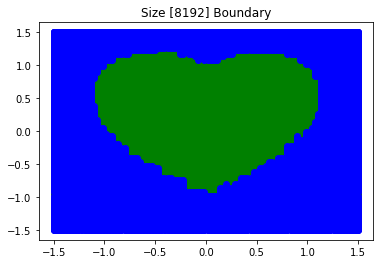

In [20]:
df_big= np.array(pd.read_csv('data\Dbig.txt', sep='\s+', header=None))

np.random.shuffle(df_big)
df_test = df_big[8192:,:]
df_big = df_big[:8192,:]
nodes= []
errs= []


size_set= np.array([32,128,512,2048,8192]).reshape(5,1)
dt= DecTree()
for size in size_set:
    df_train= df_big[:size[0],:]
    root= dt.make_subtree(df_train)
    dt.plot_boundary(df_train,root,100,"Size "+str(size)+" Boundary",filename="size_"+str(size)+"_boundary.png")
    nodes.append(dt.count_num_node(root))
    errs.append(dt.calc_error(root,df_test))

In [5]:
nodes= np.array(nodes).reshape(5,1)
errs= np.array(errs).reshape(5,1)

temp= np.concatenate((size_set,nodes,errs),axis=1)
df= pd.DataFrame(data=temp,columns=['Size','n','err'])
print(df)

     Size      n       err
0    32.0   13.0  0.155420
1   128.0   25.0  0.089602
2   512.0   69.0  0.082412
3  2048.0  133.0  0.049779
4  8192.0  273.0  0.021018


Text(0, 0.5, 'Error')

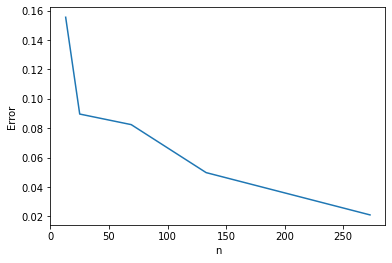

In [10]:
plt.plot(nodes,errs)
plt.xlabel("n")
plt.ylabel("Error")

In [13]:
from sklearn.tree import DecisionTreeClassifier as DTC
nodes_sklearn= []
errs_sklearn= []

dtc= DTC(criterion='entropy')
for size in size_set:
    df_train = df_big[:size[0],:]
    dtc.fit(df_train[:,:-1],df_train[:,-1])
    errs_sklearn.append(1-dtc.score(df_test[:,:-1],df_test[:,-1]))
    
    nodes_sklearn.append(dtc.tree_.node_count)
    
nodes_sklearn= np.array(nodes_sklearn).reshape(5,1)

errs_sklearn= np.array(errs_sklearn).reshape(5,1)
temp= np.concatenate((size_set,nodes_sklearn,errs_sklearn),axis=1)
df= pd.DataFrame(data=temp,columns=['size','nodes','err'])
print(df)

     size  nodes       err
0    32.0    9.0  0.116704
1   128.0   19.0  0.083518
2   512.0   49.0  0.054757
3  2048.0   97.0  0.023783
4  8192.0  231.0  0.011062


Text(0, 0.5, 'Error')

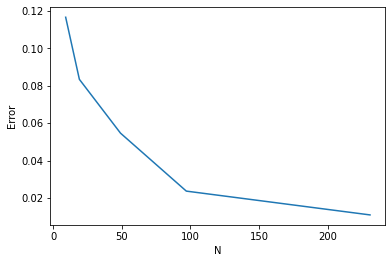

In [16]:
plt.plot(nodes_sklearn,errs_sklearn)
plt.xlabel("N")
plt.ylabel("Error")